## **1. Mount google drive**
---

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **2. Import Major Libraries**
---

In [ ]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import resource
import datetime as dt


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import concatenate

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.7.0
numpy:       1.19.5
matplotlib:  3.2.2
sklearn:     0.22.2.post1


## **3.Create a function to plot image without axis**
## **4. Set matplotlib to have seaborn plot style**

---

In [ ]:
def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

print(implt)

plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

<function implt at 0x7fafc38593b0>
Matplotlib setup completes.


## **5. Load Covid Vaccine data only**
---
* Load the previously cleaned dataset

In [ ]:
DIR = '/content/gdrive/My Drive/iss/covid/data/'

import pickle 

X_train = pickle.load(open(DIR+"X_train_probaML_random21.sav", 'rb'))
X_test = pickle.load(open(DIR+"X_test_probaML_random21.sav", 'rb'))
y_train = pickle.load(open(DIR+"y_train_probaML_random21.sav", 'rb'))
y_test = pickle.load(open(DIR+"y_test_probaML_random21.sav", 'rb'))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(366577, 63)
(366577,)
(91645, 63)
(91645,)


In [ ]:
X_train_left = X_train[:,:59]
X_train_right = X_train[:,59:]

print(X_train_left.shape)
print(X_train_right.shape)


X_test_left = X_test[:,:59]
X_test_right = X_test[:,59:]

print(X_test_left.shape)
print(X_test_right.shape)

(366577, 59)
(366577, 4)
(91645, 59)
(91645, 4)


In [ ]:
X_test_right

array([[0.03521583, 0.03167423, 0.02986526, 0.0504878 ],
       [0.02395843, 0.00757213, 0.00830592, 0.00195231],
       [0.03030736, 0.00899205, 0.00381273, 0.01816417],
       ...,
       [0.02852814, 0.01484294, 0.01488074, 0.02143011],
       [0.12630737, 0.08275489, 0.12069812, 0.0482524 ],
       [0.02791511, 0.00931958, 0.00618495, 0.00820209]])

## **6. Define the wBNRg model (to be completed)**
___
* Step 1: Setup the optimizer to be used for training
* Step 2: Set a name for the coming model (required for saving)
* Step 3: Define the convolutional neural network model (to be completed)
* Step 4: Create models for training and testing
* Step 5: Display the summary of the model of interest 

In [ ]:
lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,
    decay_steps=75,
    decay_rate=0.3)
optmz       = optimizers.Adam(learning_rate=lr_schedule)                                     
class_weight = {0:0.1, 1: 1.5}
modelname   = 'Covid-Hospitalization-Prediction-ML'                             # Step 2
now = dt.datetime.now().strftime("%m%d-%H%M%S")

                                                                                # Step 3
def createModel():
    Lin   = Input(shape=(59), name = 'leftIn')
    Lx       = Dense(100,activation='relu')(Lin)
    Lx       = BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True)(Lx)
    Lx       = Dense(50,kernel_regularizer=regularizers.l2(0.001))(Lx)
    Lx       = BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True)(Lx)
    Lx       = Activation('relu')(Lx)
    Lx       = Dense(1,activation='relu',kernel_regularizer=regularizers.l2(0.15))(Lx)
    
    Rin      = Input(shape=(X_train_right.shape[1]), name = 'RightIn')
    Rx       = Dense(30,activation='relu',kernel_regularizer=regularizers.l2(0.1))(Rin)
    Rx       = BatchNormalization(momentum=0.99, epsilon=0.01, center=True, scale=True)(Rx)
    # Rx       = Dense(1,activation='relu',kernel_regularizer=regularizers.l2(0.1))(Rx)

    x       = concatenate([Lx,Rx], axis=-1)
    x       = Dense(30,activation='relu',kernel_regularizer=regularizers.l2(0.25))(x)
    x       = BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True)(x)
    x       = Dense(1,activation='sigmoid',kernel_regularizer=regularizers.l2(0.5))(x)
    
    model     = Model(inputs=[Lin,Rin],outputs=x)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=optmz, 
                  metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.BinaryCrossentropy(),
                           tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()])
    return model

                                                                                # Step 4
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()                                                                 # Step 5

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 leftIn (InputLayer)            [(None, 59)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          6000        ['leftIn[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 100)         400         ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dense_1 (Dense)                (None, 50)           5050        ['batch_normalization[0][0]']

## **7. Create the checkpoints to be applied during training**
---
* Step 1: Create a checkpoint to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a checkpoint to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two checkpoint objects into a list

In [ ]:
                                                                                # Step 1
folderpath      = DIR
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_binary_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/gdrive/My Drive/iss/covid/data/Covid-Hospitalization-Prediction-ML.hdf5
Path to log:   /content/gdrive/My Drive/iss/covid/data/Covid-Hospitalization-Prediction-ML.csv


## **8. Train the deep learning model**
___

In [ ]:
model.fit([X_train_left,X_train_right],                                         # Training data [X_test_left,X_test_right]
# model.fit(X_train,                                                              # Training data
          y_train,                                                              # Training label
          # validation_data=(X_test, y_test),                                     # Validation data and label
          validation_data=([X_test_left,X_test_right], y_test),                                     # Validation data and label
          epochs=20,                                                            # The amount of epochs to be trained
          batch_size=3500,
          # class_weight=class_weight,                   
          shuffle=True,                                                         # To shuffle the training data
          callbacks=callbacks_list,)                                             # Callbacks to execute the checkpoints

Epoch 1/20
105/105 [==============================] - 5s 30ms/step - loss: 1.4597 - binary_accuracy: 0.9454 - binary_crossentropy: 0.3450 - false_positives: 13213.0000 - false_negatives: 6790.0000 - val_loss: 0.4198 - val_binary_accuracy: 0.9373 - val_binary_crossentropy: 0.3210 - val_false_positives: 0.0000e+00 - val_false_negatives: 5746.0000
Epoch 2/20
105/105 [==============================] - 3s 25ms/step - loss: 0.3364 - binary_accuracy: 0.9620 - binary_crossentropy: 0.2446 - false_positives: 6315.0000 - false_negatives: 7623.0000 - val_loss: 0.3921 - val_binary_accuracy: 0.9373 - val_binary_crossentropy: 0.3033 - val_false_positives: 0.0000e+00 - val_false_negatives: 5746.0000
Epoch 3/20
105/105 [==============================] - 3s 25ms/step - loss: 0.3200 - binary_accuracy: 0.9627 - binary_crossentropy: 0.2322 - false_positives: 5934.0000 - false_negatives: 7732.0000 - val_loss: 0.3839 - val_binary_accuracy: 0.9373 - val_binary_crossentropy: 0.2967 - val_false_positives: 0.000

## **9. Validate the deep learning model**
---
* Step 1: Load the trained weights and compile the model
* Step 2: Make prediction


In [ ]:
                                                                                # Step 1
modelGo.load_weights(filepath)
modelGo.compile(optimizer=optmz,
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=tf.keras.metrics.BinaryCrossentropy())

# predicts    = modelGo.predict(X_test)                                            # Step 2
print("Prediction completes.")

Prediction completes.


## **10. Report classification metrics**
---
* Step 1: Setup the label
* Step 2: Convert label from one-hot to integer
* Step 3: Calculate the accuracy score
* Step 4: Generate classification report

In [ ]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold

# estimator = KerasClassifier(build_fn=createModel, epochs=2, batch_size=128, verbose=0)
# kfold = StratifiedKFold(n_splits=2, shuffle=True)
# results = cross_val_score(estimator, X_train, encoded_y_train, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# predicts_train    = modelGo.predict(X_train)                                    # Step 2
predicts_train    = modelGo.predict([X_train_left,X_train_right])                                    # Step 2
labelname   = ['Not Hosp',          # The label for reporting metrics
               'Hospitalized']

predout_train = predicts_train.copy()
predout_train[predicts_train <= 0.5] = 0
predout_train[predicts_train > 0.5] = 1

trainScores  = metrics.accuracy_score(y_train,predout_train)                     # Step 3

                                                                                # Step 4
print("Best accuracy (on training dataset): %.4f%%" % (trainScores*100))
print(metrics.classification_report(y_train,predout_train,target_names=labelname,digits=4))

Best accuracy (on training dataset): 96.55%
              precision    recall  f1-score   support

    Not Hosp     0.9708    0.9930    0.9818    343676
Hospitalized     0.8408    0.5518    0.6663     22901

    accuracy                         0.9655    366577
   macro avg     0.9058    0.7724    0.8241    366577
weighted avg     0.9627    0.9655    0.9621    366577



In [ ]:
# predicts    = modelGo.predict(X_test)                                           # Step 2
predicts    = modelGo.predict([X_test_left,X_test_right])                                           # Step 2
labelname   = ['Not Hosp',          # The label for reporting metrics
               'Hospitalized']

predout = predicts.copy()
predout[predicts <= 0.5] = 0
predout[predicts > 0.5] = 1
# testout     = np.argmax(y_test,axis=1)

testScores  = metrics.accuracy_score(y_test,predout)                            # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.4f%%" % (testScores*100))
print(metrics.classification_report(y_test,predout,target_names=labelname,digits=4))

Best accuracy (on testing dataset): 95.48%
              precision    recall  f1-score   support

    Not Hosp     0.9640    0.9887    0.9762     85899
Hospitalized     0.7257    0.4485    0.5544      5746

    accuracy                         0.9548     91645
   macro avg     0.8449    0.7186    0.7653     91645
weighted avg     0.9491    0.9548    0.9497     91645



In [ ]:
trainScores*100, testScores*100,metrics.f1_score(y_train,predout_train),metrics.f1_score(y_test,predout)

(96.54751934791325, 95.47929510611598, 0.6663327181650408, 0.5543723781865117)

In [ ]:
modelGo.predict([X_test_left[0,:].reshape(1,-1),X_test_right[0,:].reshape(1,-1)])


array([[0.18171674]], dtype=float32)

In [ ]:
X_test_left[0,:].reshape(1,-1).shape

(1, 59)

In [ ]:
# check = [predicts, y_test, predout, testout]

# for i in ls:
#   print(i,check[0][i],check[1][i],check[2][i],check[3][i])
#   break

# display(pd.DataFrame(X_test).loc[ls_fp,:])

# pd.DataFrame(X_test).loc[ls_fp,:].sum(axis=0)
# # pd.DataFrame(y_test).loc[ls_fn,:]

## **11. Print confusion matrix**
---

In [ ]:
confusion   = metrics.confusion_matrix(y_test,predout)
print(confusion)

[[84925   974]
 [ 3169  2577]]


## **12. Plot curves on validation loss and accuracy**
---

In [ ]:
records     = pd.read_csv(folderpath+modelname +'.csv')
test_length = X_test_left.shape[0]
train_length = X_train_left.shape[0]
plt.figure()
plt.subplot(221)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
#plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(222)
plt.plot(records['val_binary_accuracy'],label="validation")
plt.plot(records['binary_accuracy'],label="training")
# plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)


plt.subplot(223)
plt.plot(records['val_false_negatives']/test_length,label="validation")
plt.plot(records['false_negatives']/train_length,label="training")
# plt.yticks([0.5,0.6,0.7,0.8])
plt.title('false_negatives',fontsize=12)


plt.subplot(224)
plt.plot(records['val_false_positives']/test_length,label="validation")
plt.plot(records['false_positives']/train_length,label="training")
# plt.yticks([0.5,0.6,0.7,0.8])
plt.title('false_positives',fontsize=12)
ax.legend()
plt.show()

## **13. Save the model plot**
---

Path to plot: /content/gdrive/My Drive/iss/covid/data/1113-025425_plot.png


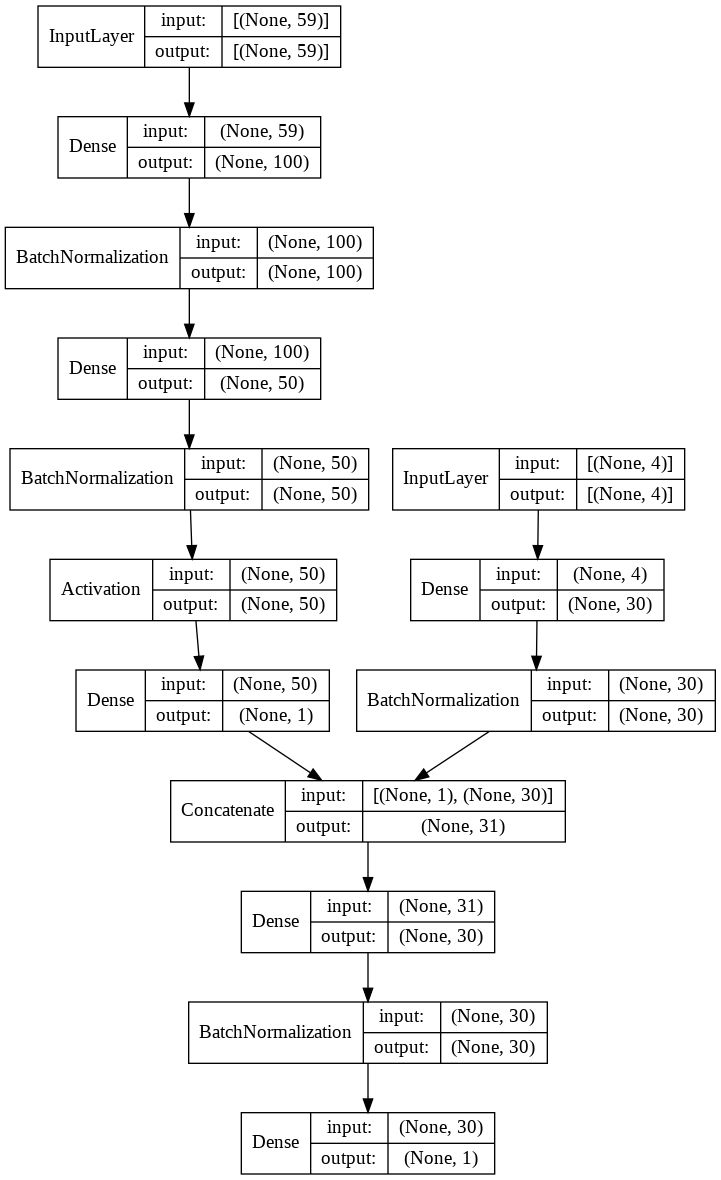

In [ ]:
plotpath  = folderpath+now+'_plot.png'
plot_model(modelGo, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

plot_model(modelGo, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

In [ ]:
# records     = pd.read_csv(folderpath+modelname +'.csv')
# plt.figure()
# plt.subplot(221)
# plt.plot(records['val_loss'], label="validation")
# plt.plot(records['loss'],label="training")
# # plt.yticks([0.00,0.50,1.00,1.50])
# plt.title('Loss value',fontsize=12)

# ax          = plt.gca()
# ax.set_xticklabels([])

# plt.subplot(222)
# plt.plot(records['val_binary_accuracy'],label="validation")
# plt.plot(records['binary_accuracy'],label="training")
# # plt.yticks([0.5,0.6,0.7,0.8])
# plt.title('Accuracy',fontsize=12)


# plt.subplot(223)
# plt.plot(records['val_false_negatives'],label="validation")
# plt.plot(records['false_negatives'],label="training")
# plt.yticks([0.5,0.6,0.7,0.8])
# plt.title('false_negatives',fontsize=12)


# plt.subplot(224)
# plt.plot(records['val_false_positives'],label="validation")
# plt.plot(records['false_positives'],label="training")
# # plt.yticks([0.5,0.6,0.7,0.8])
# plt.title('false_positives',fontsize=12)
# ax.legend()
# plt.show()